In [1]:
import mglearn
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

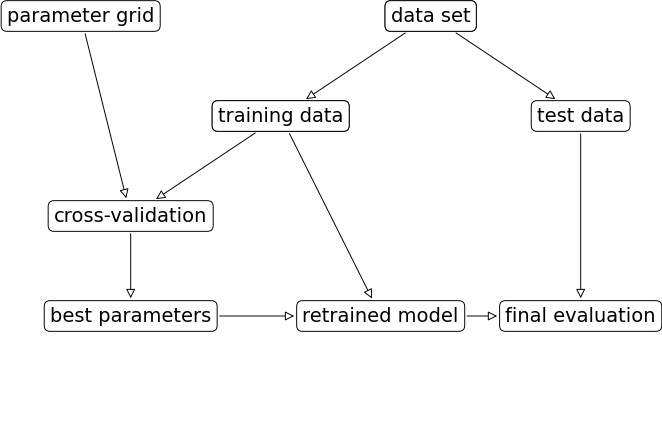

In [4]:
mglearn.plots.plot_grid_search_overview()

In [2]:
dat = pd.read_csv("demo-spotify.csv")

For GridSearchCV we need an instantiated model and parameter grid

The method considers product of the sets and evaluates each combination one by one.

The standard preparation:

In [3]:
# Define features and target
X = dat.drop(columns=['genre'])
y = dat['genre']

# Check for non-numeric columns
non_numeric_cols = X.select_dtypes(include=['object']).columns

# Drop non-numeric columns
X = X.drop(columns=non_numeric_cols)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=808)

rf = RandomForestClassifier()

Now we will construct our parameter grid

In [4]:
param_grid = {
    "n_estimators": [10, 50, 100, 200],
    "max_depth": [5, 10, 20, None],
    "max_features": ["sqrt", 9, None]
}
# Gonna end up with 48 model results. 4x4x3
# rf = classifier
gs = GridSearchCV(rf, param_grid=param_grid, n_jobs=-1, return_train_score=True) # specify the number of cores to use
# -1 means to use all the cores, you can run in parallel rather than running end to end

The GridSearchCV object above behaves like a classifier. We can call fit, predict or score on it.

In [5]:
# Carry out the search 
gs.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 20, None],
                         'max_features': ['sqrt', 9, None],
                         'n_estimators': [10, 50, 100, 200]},
             return_train_score=True)

In [6]:
# Get the best hyperparameter values
gs.best_params_

{'max_depth': 20, 'max_features': 9, 'n_estimators': 100}

It is often helpful to visualize results of all cross-validation experiments.
You can access this information using cv_results_ attribute of a fitted GridSearchCV object.

In [8]:
results = pd.DataFrame(gs.cv_results_)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.226286,0.011056,0.016284,0.001741,5,sqrt,10,"{'max_depth': 5, 'max_features': 'sqrt', 'n_es...",0.876330,0.878056,...,0.874590,0.004607,48,0.884582,0.886020,0.875665,0.886891,0.884087,0.883449,0.004019
1,0.995885,0.020648,0.031431,0.002928,5,sqrt,50,"{'max_depth': 5, 'max_features': 'sqrt', 'n_es...",0.878056,0.881219,...,0.879538,0.003463,46,0.886883,0.888034,0.890407,0.890703,0.890199,0.889245,0.001512
2,1.988634,0.067058,0.048675,0.001290,5,sqrt,100,"{'max_depth': 5, 'max_features': 'sqrt', 'n_es...",0.879781,0.883520,...,0.881896,0.001874,43,0.888106,0.889041,0.890767,0.891278,0.889840,0.889806,0.001146
3,3.992596,0.194398,0.086304,0.002882,5,sqrt,200,"{'max_depth': 5, 'max_features': 'sqrt', 'n_es...",0.881507,0.885246,...,0.881781,0.001912,44,0.891701,0.889544,0.890119,0.890199,0.891062,0.890525,0.000762
4,0.415127,0.012222,0.015018,0.000226,5,9,10,"{'max_depth': 5, 'max_features': 9, 'n_estimat...",0.878343,0.880357,...,0.880803,0.004664,45,0.888393,0.890695,0.891054,0.888617,0.890343,0.889821,0.001099


Let's look at only the most relevant rows

In [ ]:
# Select relevant columns
filtered_results = pd.DataFrame(gs.cv_results_)[
    [
        "mean_test_score",
        "param_n_estimators",   # Number of trees
        "param_max_depth",      # Max depth of trees
        "param_max_features",   # Feature selection per split
        "mean_fit_time",        # Time taken to fit the model
        "rank_test_score",      # Rank of the best score
    ]
].set_index("rank_test_score").sort_index().T

Other than searching for best hyperparameter values, GridSearchCV also fits a new model on the whole training set with the parameters that yielded the best results.
So we can conveniently call score on the test set with a fitted GridSearchCV object.

In [ ]:
# Best score

# Get the test scores 


Why are best_score_ and the score above different?



Visualizing parameters as heat 

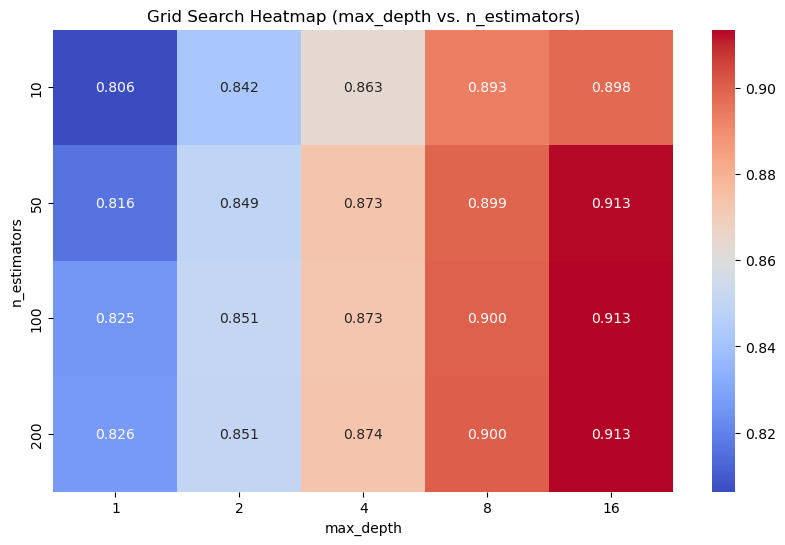

In [10]:
def display_heatmap(param_grid, model, X_train, y_train):
   
    grid_search = GridSearchCV(
        model, param_grid, cv=5, n_jobs=-1, return_train_score=True, scoring="accuracy"
    )
    
    # Fit the model
    grid_search.fit(X_train, y_train)
    
    # Convert results to DataFrame
    results = pd.DataFrame(grid_search.cv_results_)

    # Extract parameter names dynamically
    param_x, param_y = list(param_grid.keys())

    # Reshape test scores into a 2D array for heatmap
    scores = results.pivot(index=f"param_{param_y}", columns=f"param_{param_x}", values="mean_test_score")

    # Plot the heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(scores, annot=True, fmt=".3f", cmap="coolwarm")
    plt.xlabel(param_x)
    plt.ylabel(param_y)
    plt.title(f"Grid Search Heatmap ({param_x} vs. {param_y})")
    plt.show()

# Define the hyperparameter grid for max_depth vs. n_estimators
param_grid1 = {
    "max_depth": [1,2,4,8,16],
    "n_estimators": [10,50,100,200]
}


# Call the function
display_heatmap(param_grid1, rf, X_train, y_train)

A key problem with exhaustive grid search is the required number of models to evaluate grows exponentially with the dimensionally of the configuration space.

For future discussion:
sklearn.model_selection.RandomizedSearchCV
Samples configurations at random until certain budget (e.g., time) is exhausted.